# Getting Started with cuML's accelerator mode (cuml.accel)


cuML is a Python GPU library for accelerating machine learning models using a scikit-learn-like API.

cuML now has an accelerator mode (cuml.accel) which allows you to bring accelerated computing to existing workflows with zero code changes required. In addition to scikit-learn, cuml.accel also provides acceleration to algorithms found in umap-learn (UMAP) and hdbscan (HDBSCAN).

This notebook is a brief introduction to cuml.accel.

# ⚠️ Verify your setup

First, we'll verfiy that we are running on an NVIDIA GPU:

In [1]:
!nvidia-smi  # this should display information about available GPUs

Wed Mar  5 21:54:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

We'll also check to make sure a recent version of cuML is installed:

In [2]:
!pip install \
    --extra-index-url=https://pypi.nvidia.com \
    "cuml-cu12==25.2.*"

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 118.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.9/133.9 kB 50.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.0/405.0 MB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 851.2/851.2 kB 101.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.5/293.5 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.7/557.7 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.3/27.3 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

With classical machine learning, there is a wide range of interesting problems we can explore. In this tutorial we'll examine 3 of the more popular use cases: classification, clustering, and dimensionality reduction.

# Classification

Let's load a dataset and see how we can use scikit-learn to classify that data.  For this example we'll use the Coverage Type dataset, which contains a number of features that can be used to predict forest cover type, such as elevation, aspect, slope, and soil-type.

More information on this dataset can be found at https://archive.ics.uci.edu/dataset/31/covertype.

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
# from sklearn.preprocessing import LabelEncoder


In [4]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"

# Column names for the dataset (from UCI Covertype description)
columns = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
           'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
           'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
           'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6',
           'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13',
           'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
           'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27',
           'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
           'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40', 'Cover_Type']

data = pd.read_csv(url, header=None)
data.columns=columns

In [5]:
data.shape

(581012, 55)

Next, we'll separate out the classification variable (Cover_Type) from the rest of the data. This is what we will aim to predict with our classification model. We can also split our dataset into training and test data using the scikit-learn train_test_split function.

In [6]:
X, y = data.drop('Cover_Type', axis=1), data['Cover_Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Now that we have our dataset split, we're ready to run a model. To start, we will just run the model with the default sklearn configuration. Note that we can set n_jobs=-1 to utilize all available CPU cores for fitting the trees -- this will ensure we get the best performance possible on our system's CPU.  

In [7]:
%%time

clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
clf.fit(X_train, y_train)

CPU times: user 3min, sys: 1.28 s, total: 3min 1s
Wall time: 2min 7s


RandomForestClassifier(n_jobs=-1)

In just 2 minutes, we were able to fit our tree model using scikit-learn. This is not bad! Let's use the model we just trained to predict coverage types in our test dataset and take a look at the accuracy of our model.

In [8]:
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9542094438181459

We can also print out a full classification report to better understand how we predicted different Coverage_Type categories.

In [9]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.96      0.94      0.95     42460
           2       0.95      0.97      0.96     56522
           3       0.95      0.96      0.95      7184
           4       0.91      0.88      0.89       534
           5       0.94      0.77      0.85      1919
           6       0.93      0.91      0.92      3420
           7       0.97      0.94      0.96      4164

    accuracy                           0.95    116203
   macro avg       0.94      0.91      0.93    116203
weighted avg       0.95      0.95      0.95    116203



With scikit-learn, we built a pretty good model that was able to be trained in just a couple minutes. Often we want to run several different random forest models in order to optimize our hyperparameters. For example, we may want to increase the number of estimators, or modify the maximum depth of our tree. When running dozens or hundreds of different hyperparameter combinations, things start to become quite slow and iteration takes a lot longer.

We provide some sample code utilizing GridSearchCV below to show what this process might look like. All of these combinations would take a LONG time to run if we spend 2 minutes fitting each model.

In [10]:
"""
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
"""

"\nfrom sklearn.model_selection import GridSearchCV\n\n# Define the parameter grid to search over\nparam_grid = {\n    'n_estimators': [50, 100, 200],\n    'max_depth': [None, 10, 20, 30],\n    'min_samples_split': [2, 5, 10],\n    'min_samples_leaf': [1, 2, 4],\n    'max_features': ['auto', 'sqrt', 'log2'],\n    'bootstrap': [True, False]\n}\n\ngrid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5)\ngrid_search.fit(X_train, y_train)\n"

Now let's load cuml.accel and try running the same code again to see what kind of acceleration we can get.

In [11]:
# from cuml.internals import logger
# logger.set_level(logger.level_enum.info)
%load_ext cuml.accel

[2025-03-05 21:59:58.120] [CUML] [info] cuML: Installed accelerator for sklearn.
[2025-03-05 22:00:26.850] [CUML] [info] cuML: Installed accelerator for umap.
[2025-03-05 22:00:26.943] [CUML] [info] cuML: Installed accelerator for hdbscan.
[2025-03-05 22:00:26.943] [CUML] [info] cuML: Successfully initialized accelerator.


After loading the IPython magic, we need to import the sklearn estimators we wish to use again.

In [12]:
from sklearn.ensemble import RandomForestClassifier

In [17]:
%%time

clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
clf.fit(X_train, y_train)

CPU times: user 2.77 s, sys: 2.04 s, total: 4.81 s
Wall time: 3.82 s


RandomForestClassifier(n_jobs=-1)

That was much faster! Using cuML we're able to train this random forest model in just seconds instead of minutes. Let's take a look at the same accuracy score and classification report to compare the model's performance.

In [18]:
y_pred = clf.predict(X_test)
cr = classification_report(y_test, y_pred)
print(cr)

Out of the box, the model didn't perform quite as well as the scikit-learn implementation. cuML's random forest implementation defaults to a max_depth of 16 for our trees, which can lead to lower accuracy on larger datasets.

Because my model ran so much faster, I can quickly iterate on the hyperparameter configuration and find a model that performs better with excellent speedups.

In [20]:
%%time

clf = RandomForestClassifier(n_estimators=100, max_features=1.0, max_depth=30)
clf.fit(X_train, y_train)

CPU times: user 9.23 s, sys: 6.24 s, total: 15.5 s
Wall time: 19.3 s


RandomForestClassifier(max_depth=30, max_features=1.0)

In [21]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.97      0.96      0.96     42460
           2       0.97      0.97      0.97     56522
           3       0.96      0.96      0.96      7184
           4       0.91      0.88      0.89       534
           5       0.93      0.85      0.89      1919
           6       0.94      0.93      0.93      3420
           7       0.97      0.95      0.96      4164

    accuracy                           0.96    116203
   macro avg       0.95      0.93      0.94    116203
weighted avg       0.96      0.96      0.96    116203



With a model that runs in just seconds, we can perform hyperparameter optimization using a method like the grid search shown above, and have results in just minutes instead of hours.

There are some algorithms and functionality from scikit-learn, UMAP, and HDBSCAN that are *not* implemented in cuML. For cases where the underlying functionality is not supported on GPU, the cuML accelerator will gracefully fall back and execute on the CPU instead.


In [26]:
from sklearn.neighbors import KernelDensity
import numpy as np

X = np.concatenate((np.random.normal(0, 1, 10000),
                    np.random.normal(5, 1, 10000)))[:, np.newaxis]


In [27]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.5)
kde.fit(X)


KernelDensity(bandwidth=0.5)

In [28]:
kde.score_samples(X)

array([-2.09979829, -1.77490047, -1.76820974, ..., -2.74268225,
       -1.74159788, -1.75247281])

We can restart the kernel to unload the accelerator extension and observe the same performance comparisons on a few other algorithms.

In [29]:
get_ipython().kernel.do_shutdown(restart=True)

{'status': 'ok', 'restart': True}

Next let's take a look at a clustering example using HDBSCAN.


# Clustering

Clustering is an important data science workflow because it helps uncover hidden patterns and structures within data without requiring labeled outcomes. In practice, with high dimensional data it can be difficult to discern whether the clusters we've chosen are good or not.

HDBSCAN is a popular density-based clustering algorithm that is highly flexible. We'll load a toy sklearn dataset to illustrate how HDBSCAN can be accelerated with cuml.accel.

In [5]:
import hdbscan
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons
from sklearn.metrics import silhouette_score

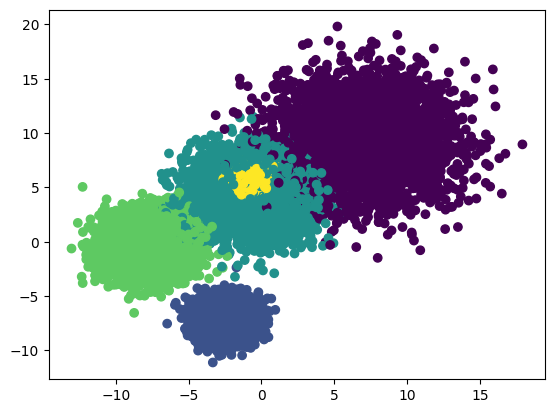

In [12]:
N = 20000
K = 100

X, y = make_blobs(
    n_samples=N,
    n_features=K,
    centers=5,
    cluster_std=[3,1,2,1.5,0.5]
)

plt.scatter(X[:, 0], X[:, 1], c=y)



In [13]:
clf_cpu = hdbscan.HDBSCAN()
%time clf_cpu.fit(X)


print(silhouette_score(X, clf_cpu.labels_))


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CPU times: user 47.6 s, sys: 153 ms, total: 47.8 s
Wall time: 47.8 s
0.7129044066926106


In [14]:
%load_ext cuml.accel

[2025-03-05 23:09:23.656] [CUML] [info] cuML: Installed accelerator for sklearn.
[2025-03-05 23:09:37.476] [CUML] [info] cuML: Installed accelerator for umap.
[2025-03-05 23:09:37.477] [CUML] [info] cuML: Installed accelerator for hdbscan.
[2025-03-05 23:09:37.477] [CUML] [info] cuML: Successfully initialized accelerator.


In [15]:
import hdbscan

In [16]:
clf = hdbscan.HDBSCAN()
%time clf.fit(X)


CPU times: user 687 ms, sys: 289 ms, total: 976 ms
Wall time: 2.57 s


HDBSCAN()

In [17]:
print(silhouette_score(X, clf.labels_))


0.7129044066926106



In this example, the silhouette score for the CPU and GPU runs were actually identical. It's important to note that on real-world datasets, these numbers will often differ slightly. This toy dataset is very easy for a powerful algorithm like HDBSCAN to cluster, but a bit of variance in the silhouette score is normal in practice.

Lastly, let's take a look at how we can use cuml's accelerator mode for a third popular machine learning task -- dimensionality reduction. We'll restart the kernel to unload the extension yet again.

In [29]:
get_ipython().kernel.do_shutdown(restart=True)

{'status': 'ok', 'restart': True}

# Dimensionality Reduction

UMAP is a popular dimensionality reduction technique that is used to help visualize cluster very wide datasets. It can be used in combination with other algorithms, e.g. use UMAP to reduce the dimensionality of a wide dataset, then use HDBSCAN to cluster the resulting embeddings.

To explore how cuML can accelerate UMAP, let's load in another dataset from UCI. We'll use the Human Activity Recognition (HAR) dataset, which was created from recordings of 30 subjects performing activities of daily living (ADL) while carrying a waist-mounted smartphone with embedded inertial sensors.

In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip -O /tmp/HAR_data.zip

--2025-03-05 23:13:19--  https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘/tmp/HAR_data.zip’

/tmp/HAR_data.zip       [      <=>           ]  58.17M  55.1MB/s    in 1.1s    

2025-03-05 23:13:21 (55.1 MB/s) - ‘/tmp/HAR_data.zip’ saved [60999314]



In [2]:
!unzip /tmp/HAR_data.zip -d /tmp/HAR_data/

Archive:  /tmp/HAR_data.zip
replace /tmp/HAR_data/UCI HAR Dataset/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [7]:
import pandas as pd

X_train = pd.read_csv("/tmp/HAR_data/UCI HAR Dataset/train/X_train.txt", sep="\s+", header=None)
y_train = pd.read_csv("/tmp/HAR_data/UCI HAR Dataset/train/y_train.txt", sep="\s+", header=None)
X_test = pd.read_csv("/tmp/HAR_data/UCI HAR Dataset/test/X_test.txt", sep="\s+", header=None)
y_test = pd.read_csv("/tmp/HAR_data/UCI HAR Dataset/test/y_test.txt", sep="\s+", header=None)
labels = pd.read_csv("/tmp/HAR_data/UCI HAR Dataset/activity_labels.txt", sep="\s+", header=None)

In [8]:
X_train.shape

(7352, 561)

Let's take a look at the activity labels to better understand the data we're working with. We can see that the sensors have grouped activities into 6 different classes.

In [9]:
labels

,0,1
0,1,WALKING
1,2,WALKING_UPSTAIRS
2,3,WALKING_DOWNSTAIRS
3,4,SITTING
4,5,STANDING
5,6,LAYING


In [10]:
from sklearn.preprocessing import StandardScaler

# Optional: Scale the data before applying UMAP (important for distance-based methods)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)


Let's run UMAP with some basic parameters and explore a lower-dimensionality projection of this dataset.

In [12]:
import umap
umap_model = umap.UMAP(n_neighbors=15, n_components=2, random_state=42, min_dist=0.0)

In [13]:
%%time

# Fit UMAP model to the data
X_train_umap = umap_model.fit_transform(X_train_scaled)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


CPU times: user 36.9 s, sys: 1.16 s, total: 38.1 s
Wall time: 43.1 s


It's often quite interesting to visualize the resulting projection of the embeddings created by UMAP. In this case, let's take a look at the now 2-dimensional dataset.

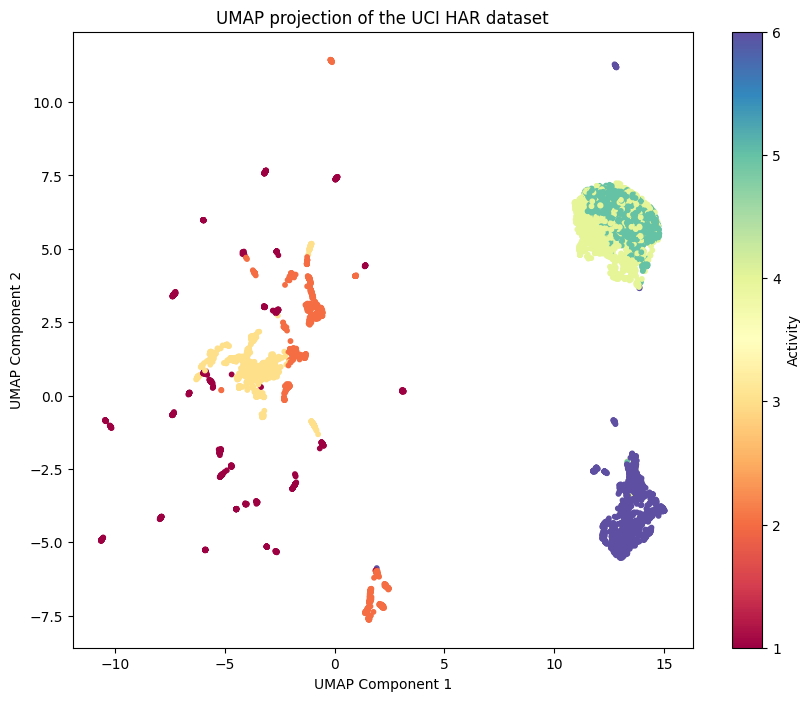

In [14]:
import matplotlib.pyplot as plt

# Plot the UMAP result (2D)
plt.figure(figsize=(10, 8))
plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y_train.values.ravel(), cmap='Spectral', s=10)
plt.colorbar(label="Activity")
plt.title("UMAP projection of the UCI HAR dataset")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()


It's interesting to see how our different categories are grouped in relation to one another.

We can look at the trustworthiness score to better understand how well the structure of the original dataset was preserved by our 2D projection

In [15]:
from sklearn.manifold import trustworthiness
trustworthiness(X_train, X_train_umap, n_neighbors=15)


0.9725294692634925

It looks like this projection is a great representation of our full dataset.

Let's now run the same thing with the accelerator turned on.

In [16]:
%load_ext cuml.accel

[2025-03-05 23:21:41.061] [CUML] [info] cuML: Installed accelerator for sklearn.
[2025-03-05 23:21:41.068] [CUML] [info] cuML: Installed accelerator for umap.
[2025-03-05 23:21:41.093] [CUML] [info] cuML: Installed accelerator for hdbscan.
[2025-03-05 23:21:41.093] [CUML] [info] cuML: Successfully initialized accelerator.


In [17]:
import umap
umap_model = umap.UMAP(n_neighbors=15, n_components=2, random_state=42, min_dist=0.0)

[2025-03-05 23:21:48.478] [CUML] [info] build_algo set to brute_force_knn because random_state is given


In [18]:
%%time

# Fit UMAP model to the data
X_train_umap = umap_model.fit_transform(X_train_scaled)

CPU times: user 423 ms, sys: 204 ms, total: 628 ms
Wall time: 639 ms


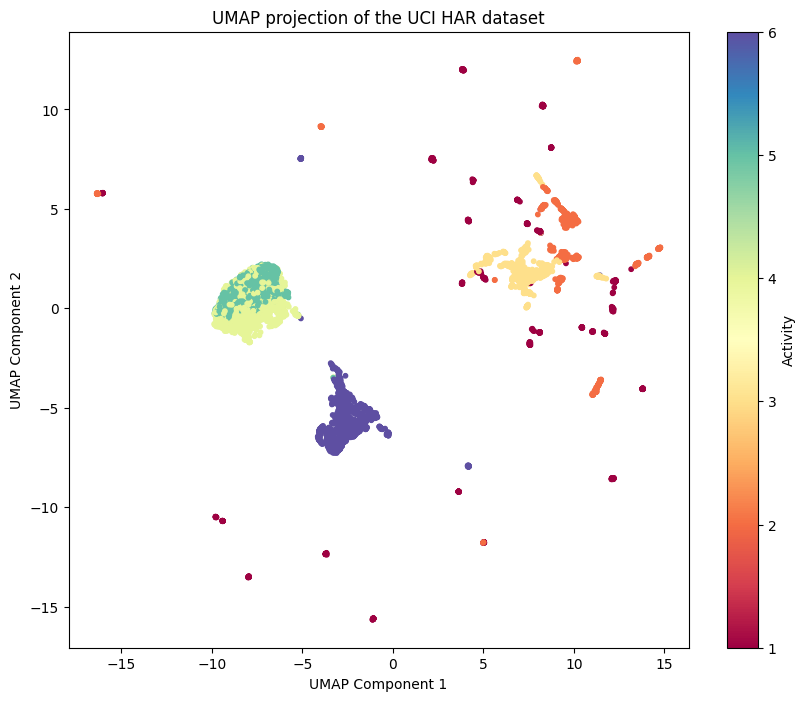

In [19]:
import matplotlib.pyplot as plt

# Plot the UMAP result (2D)
plt.figure(figsize=(10, 8))
plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y_train.values.ravel(), cmap='Spectral', s=10)
plt.colorbar(label="Activity")
plt.title("UMAP projection of the UCI HAR dataset")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()


Note that while the projection here is not identical to the umap-learn plot, the quality of the results are equivalent. We can run the trustworthiness score again to compare and verify this claim.

In [20]:
from sklearn.manifold import trustworthiness
trustworthiness(X_train, X_train_umap, n_neighbors=15)


0.9708467729942112

In [21]:
# Scratch: Potential 3D plot instead

from mpl_toolkits.mplot3d import Axes3D



In [ ]:
# Change the number of components to 3 for 3D visualization
umap_model = umap.UMAP(n_neighbors=15, n_components=3, random_state=42)

# Fit UMAP model to the data
X_train_umap = umap_model.fit_transform(X_train_scaled)



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


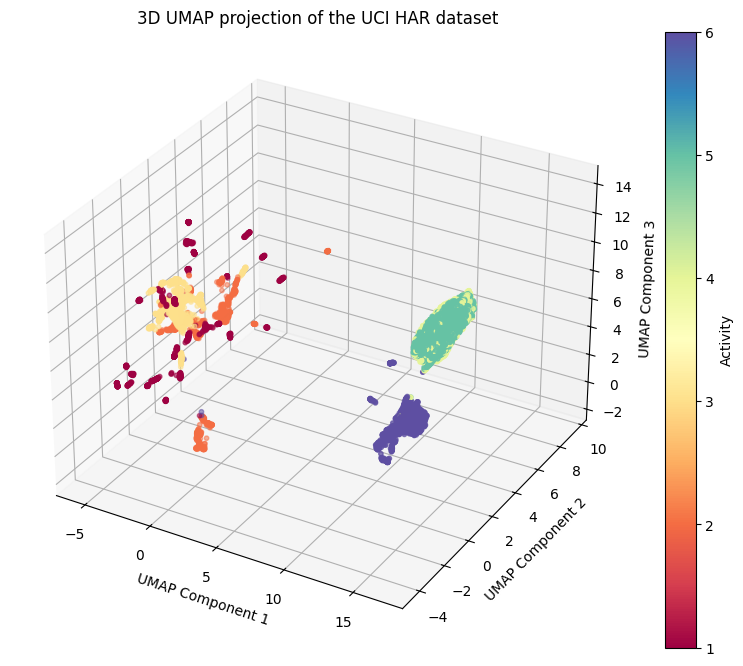

In [ ]:
# Plotting 3D UMAP result
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_train_umap[:, 0], X_train_umap[:, 1], X_train_umap[:, 2], c=y_train.values.ravel(), cmap='Spectral', s=10)
plt.colorbar(scatter, label="Activity")
ax.set_title("3D UMAP projection of the UCI HAR dataset")
ax.set_xlabel("UMAP Component 1")
ax.set_ylabel("UMAP Component 2")
ax.set_zlabel("UMAP Component 3")
plt.show()